In [1]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)
    
from src.predictionModule.TreeTimeML import TreeTimeML
from src.predictionModule.LoadupSamples import LoadupSamples

import pandas as pd
import numpy as np
import polars as pl
import datetime
import seaborn as sns
import lightgbm as lgb
import random
import matplotlib.pyplot as plt
import logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(message)s'
)
logger = logging.getLogger(__name__)

In [2]:
params = {
    "idxAfterPrediction": 1,
    'timesteps': 65,
    'target_option': 'last',
    'LoadupSamples_time_scaling_stretch': False,
    'LoadupSamples_tree_scaling_standard': False,
    "LoadupSamples_time_inc_factor": 10,
    
    "LSTM_units": 32,
    "LSTM_num_layers": 1,
    "LSTM_batch_size": 2**12,
    "LSTM_epochs": 3,
}

In [3]:

stock_group = "group_snp500_finanTo2011"

eval_date = datetime.date(year=2025, month=2, day=13)
start_train_date = datetime.date(year=2014, month=1, day=1)

ls = LoadupSamples(
    train_start_date=start_train_date,
    test_dates=[eval_date],
    group=stock_group,
    params=params,
)

In [4]:
ls.load_samples(main_path = "../src/featureAlchemy/bin/")

In [5]:
Xtree = ls.train_Xtree
ytree = ls.train_ytree
Xtime = ls.train_Xtime
ytime = ls.train_ytime

treenames = ls.featureTreeNames
timenames = ls.featureTimeNames

In [6]:
np.mean(ytree)

np.float32(1.000506)

## Allg Ideen

In [31]:
# Linear
def f(q):
    mask = np.ones(Xtree.shape[0], dtype=bool)
    idx = np.where(timenames == 'MathFeature_TradedPrice')[0][0]
    prices = [Xtime[:, -(i + 1), idx] for i in range(4)]  # S0 to S21

    for i in range(len(prices) - 1):
        current_mask = prices[i] / prices[i + 1] > 1 + q
        print(f"Step {i}: {current_mask.sum()}")
        mask &= current_mask

    return mask

mask = f(0.005)
masksum = mask.sum()
returns = np.mean(ytree[mask])

print(f"Number of selected rows: {masksum}")
print(f"Ratio of selected rows: {masksum / len(mask):.5f}")
print(f"Mean return of selected rows: {returns}")

Step 0: 242061
Step 1: 242015
Step 2: 241929
Number of selected rows: 30334
Ratio of selected rows: 0.04528
Mean return of selected rows: 1.0001635551452637


In [35]:
# Absturz
def f(drop=0.05, lookback=60):
    """
    at least one ≥ 5 % intraday drop in the last `lookback` bars.
    """
    idx   = np.where(timenames == "MathFeature_TradedPrice")[0][0]
    mask = np.ones(Xtime.shape[0], bool)
    # --- any –5 % fall in the last 60 bars ---
    window = Xtime[:, -(lookback+1):, idx]      
    drops  = window[:, 1:] / window[:, :-1] < 1 - drop  # < 0.95
    mask &= drops.any(axis=1)

    return mask

mask = f(drop=0.05)
masksum = mask.sum()
returns = np.mean(ytree[mask])

print(f"Number of selected rows: {masksum}")
print(f"Ratio of selected rows: {masksum / len(mask):.5f}")
print(f"Mean return of selected rows: {returns}")

Number of selected rows: 205929
Ratio of selected rows: 0.30737
Mean return of selected rows: 1.0008203983306885


In [ ]:
# Machine Learning
import copy
lsc = copy.deepcopy(ls)
last_train_Date = datetime.date(year=2022, month=12, day=31)
lsc.split_dataset(start_train_date, last_train_Date)

from src.predictionModule.MachineModels import MachineModels

mm = MachineModels(params=params)
startTime  = datetime.datetime.now()
required_features = [
    "MathFeature_TradedPrice",
    "FeatureTA_High",
    "FeatureTA_Low",
    "FeatureTA_volume_obv",
    "FeatureTA_volume_vpt"
]
# Validate feature presence and retrieve indices
missing_features = [f for f in required_features if f not in lsc.featureTimeNames]
if missing_features:
    raise ValueError(f"Missing required features in featureTimeNames: {missing_features}")
idxs_features = [np.where(lsc.featureTimeNames == feature)[0][0] for feature in required_features]
lstm_model, lstm_res = mm.run_LSTM_torch(
    X_train=lsc.train_Xtime[:, :, idxs_features],
    y_train=lsc.train_ytime,
    X_test=lsc.test_Xtime[:, :, idxs_features],
    y_test=lsc.test_ytime
)
inc_factor = lsc.params['LoadupSamples_time_inc_factor']
logger.info(f"LSTM RSME: {lstm_res['val_rmse'] * 2.0 / inc_factor:.4f}")
logger.info(f"LSTM completed in {datetime.datetime.now() - startTime}.")
# LSTM Predictions
y_test_pred = mm.predict_LSTM_torch(
    lstm_model, lsc.test_Xtime[:, :, idxs_features], batch_size = lsc.params['LSTM_batch_size'], device='cpu')

print(np.mean(y_test_pred))
print(np.min(y_test_pred))
print(np.max(y_test_pred))



Epochs: 100%|██████████| 3/3 [03:20<00:00, 66.91s/it]
LSTM RSME: 0.0165
LSTM completed in 0:03:22.673136.


0.4854933
0.40439424
0.5403616


In [56]:
y_test_p = np.arctanh((y_test_pred-0.5)*2.0)/inc_factor+1.0
print(np.mean(y_test_p))
print(np.min(y_test_p))
print(np.max(y_test_p))

0.9970894
0.9806406
1.0080899


In [69]:
mask = y_test_p > 1.0005

masksum = mask.sum()
returns = np.mean(lsc.test_ytree[mask])

print(f"Number of selected rows: {masksum}")
print(f"Ratio of selected rows: {masksum / len(mask):.5f}")
print(f"Mean return of selected rows: {returns}")

Number of selected rows: 27468
Ratio of selected rows: 0.21341
Mean return of selected rows: 1.000259280204773


In [16]:
import torch
import torch.nn as nn
def establish_datesMat(dates: pl.Series, device: str) -> torch.Tensor:

    """
    Establish a sparse matrix of dates for use in the training process.
    This method is not used in the current implementation but is kept for reference.
    """
    date_counts_np = dates.value_counts(sort=False, name="count").select("count").to_numpy().squeeze()
    date_counts = torch.tensor(date_counts_np, dtype=torch.long, device=device)  # (N,)
    n_udates = date_counts.size(0)  # number of unique dates
    N = int(date_counts.sum().item()) # total number of samples
    
    dates_offsets = torch.cat([
        torch.tensor([0], device=device),
        date_counts.cumsum(0)[:-1]
    ])
    row_idx = torch.repeat_interleave(
        torch.arange(n_udates, device=device),
        date_counts
    )
    col_idx = torch.cat([
        torch.arange(s, s + length, device=device) 
        for s, length in zip(dates_offsets, date_counts)
    ])
    indices = torch.stack([row_idx, col_idx], dim=0)   # shape [2, total_ones]
    values  = torch.ones(indices.size(1), device=device)
    datesMat_sparse = torch.sparse_coo_tensor(
        indices,                       # row_idx (0…D-1), col_idx (0…N-1)
        values,
        (n_udates, N)
    ).coalesce()
    
    return datesMat_sparse.to_dense().numpy()

# Lower Resistance

In [6]:
from scipy.ndimage import minimum_filter1d
from scipy.ndimage import maximum_filter1d
def spaced_minima(arr, distance=5):
    flt = minimum_filter1d(arr, size=2*distance+1, axis=1, mode='constant', cval=np.inf)
    mask = (arr == flt)
    rows, cols = np.nonzero(mask)
    return rows, cols

In [7]:
#short test
np.random.seed(0)
arr = np.random.rand(5, 20)
minima_mask = spaced_minima(arr, distance=2)
#print("Array:\n", arr)
#print("Minima mask:\n", minima_mask)

In [40]:
from scipy.ndimage import minimum_filter1d
from scipy.ndimage import maximum_filter1d
def f(q, window_size=8, min_locs = 5, max_locs = 10, q2 = None):
    if q2 is None:
        q2 = 1-q
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(timenames == 'MathFeature_TradedPrice')[0][0]
    arr2d = Xtime[:, :, idx]
    flt_min = minimum_filter1d(arr2d, size=2*window_size+1, axis=1, mode='constant', cval=np.inf)
    #flt_max = maximum_filter1d(arr2d, size=2*5+1, axis=1, mode='constant', cval=-np.inf)
    mask_locmin = (arr2d == flt_min)
    #mask_locmax = (arr2d == flt_max)
    #mask_locmin[:, :2]  = False  # Exclude first 5 columns
    #mask_locmin[:, -2:] = False  # Exclude last 5 columns
    #mask_locmax[:, :2]  = False  # Exclude first 5 columns
    #mask_locmax[:, -2:] = False  # Exclude last 5 columns
    num_locmin = np.sum(mask_locmin, axis=1)
    #num_locmax = np.sum(mask_locmin, axis=1)
    
    minima_vals = np.where(mask_locmin, arr2d, np.nan)
    # for each row, compute span = max(minima) - min(minima)
    row_locmin_max = np.nanmax(minima_vals, axis=1)
    row_locmin_min = np.nanmin(minima_vals, axis=1)
    row_locmin_dis = row_locmin_max - row_locmin_min
    
    arr2d_min = np.min(arr2d, axis=1)
    arr2d_max = np.max(arr2d, axis=1)
    arr2d_dis = arr2d_max - arr2d_min
    
    mask_height = arr2d_dis > np.quantile(arr2d_dis, q2)  # Filter rows with significant height difference
    
    mask_nummin = (num_locmin >= min_locs)
    mask_nummax = (num_locmin <= max_locs)
    mask_end_inbetween = (arr2d[:, -1] <= row_locmin_max) & (arr2d[:, -1] >= row_locmin_min)  # here might be a problem with nan
    quant = np.quantile(row_locmin_dis[~np.isnan(row_locmin_dis)], q)
    mask_quant = (row_locmin_dis <= quant)
    
    mask = mask_nummin & mask_nummax & mask_end_inbetween & mask_quant & mask_height
    return mask


mask = f(0.1, 5, 0, 10, 0.7)
masksum = mask.sum()
returns = np.mean(ytree[mask])

print(f"Number of selected rows: {masksum}")
print(f"Ratio of selected rows: {masksum / len(mask):.5f}")
print(f"Mean return of selected rows: {returns}")

Number of selected rows: 249
Ratio of selected rows: 0.00037
Mean return of selected rows: 1.0033079385757446


In [75]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Assuming Xtree, Xtime, timenames, ytree are already in scope

# Parameter grid
grid = {
    'q': np.linspace(0.1, 0.5, 9),         # quantile thresholds from 0.1 to 0.9
    'window_size': [5, 7, 10],         # different window sizes
    'min_locs': [1, 2, 3],            # minimum number of minima
    'max_locs': [2, 3, 4,5],           # maximum number of minima
}

# Prepare to store results
results = []

total_runs = (len(grid['q']) * len(grid['window_size']) * \
              len(grid['min_locs']) * len(grid['max_locs']))
print(f"Total parameter combinations: {total_runs}")

# Grid search
tqdm_iter = tqdm(
    [(q, w, mn, mx) for q in grid['q']
                 for w in grid['window_size']
                 for mn in grid['min_locs']
                 for mx in grid['max_locs']],
    total=total_runs,
    desc='Grid Search'
)

for q, w, mn, mx in tqdm_iter:
    try:
        mask = f(q, window_size=w, min_locs=mn, max_locs=mx)
        n_selected = mask.sum()
        if n_selected == 0:
            continue  # skip if no rows selected
        mean_return = np.mean(ytree[mask])
        results.append({
            'q': q,
            'window_size': w,
            'min_locs': mn,
            'max_locs': mx,
            'n_selected': n_selected,
            'mean_return': mean_return
        })
    except Exception as e:
        # Log or handle exceptions if needed
        continue

# Compile results into DataFrame
df_results = pd.DataFrame(results)

# Sort by mean_return descending
top_results = df_results.sort_values('mean_return', ascending=False).reset_index(drop=True)

# Display top 10 combinations
print("Top 10 parameter combinations by mean return:")
print(top_results.head(10))

Total parameter combinations: 324


Grid Search:   0%|          | 0/324 [00:00<?, ?it/s]C:\Users\kimer\AppData\Local\Temp\ipykernel_18800\3608377505.py:20: RuntimeWarning: All-NaN slice encountered
  row_locmin_max = np.nanmax(minima_vals, axis=1)
C:\Users\kimer\AppData\Local\Temp\ipykernel_18800\3608377505.py:21: RuntimeWarning: All-NaN slice encountered
  row_locmin_min = np.nanmin(minima_vals, axis=1)
Grid Search: 100%|██████████| 324/324 [13:37<00:00,  2.52s/it]

Top 10 parameter combinations by mean return:
     q  window_size  min_locs  max_locs  n_selected  mean_return
0  0.1           10         1         2           2     1.021875
1  0.1           10         1         4           2     1.021875
2  0.1           10         1         5           2     1.021875
3  0.1           10         1         3           2     1.021875
4  0.1            5         2         2           6     1.017241
5  0.1            5         1         2           6     1.017241
6  0.1            7         1         2          17     1.016884
7  0.1            7         2         2          17     1.016884
8  0.1            7         2         5          29     1.016715
9  0.1            7         2         4          29     1.016715


# RSI Stats

In [43]:
q = 0.01
idx = np.where(treenames == 'FeatureTA_momentum_stoch_rsi')[0]
arr = Xtree[:, idx].flatten()
quant_lower = np.quantile(arr, q)
#quant_upper = np.quantile(arr, 1-q)
mask = np.zeros_like(arr, dtype=bool)
mask = mask | (arr <= quant_lower)
#mask = mask | (arr >= quant_upper)

print(f"Ratio of chosen: {mask.sum()/len(mask)}")
print(np.mean(ytree[mask]))

Ratio of chosen: 0.13396101701505303
1.0025375


# RSME Stats

### RSME 1, with intermediate value

In [44]:
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == 'Fourier_Price_RSMERatioCoeff_1_MH_1')[0]
    idx1 = np.where(treenames == 'FeatureTA_Open_lag_m1')[0]
    idx2 = np.where(treenames == 'FeatureTA_Open_lag_m10')[0]
    arr = Xtree[:, idx].flatten()
    arr1 = Xtree[:, idx1].flatten()
    arr2 = Xtree[:, idx2].flatten()
    mask = mask | (arr2 < arr1*0.98)
    quant = np.quantile(arr[(arr2 < arr1*0.98)], q)
    mask = mask | (arr <= quant)
    return mask

n_q = 10
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.01, 0.10, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(masksum/Xtree.shape[0])
print(returns)

[0.53465968 0.53915346 0.5437938  0.54835637 0.5530311  0.55755479
 0.56218465 0.5666545  0.57107949 0.57569141]
[1.00255799 1.00255442 1.00255322 1.00254762 1.00253785 1.0025301
 1.00252962 1.00251782 1.00250864 1.00250995]


### RSME 1, with out intermediate value

[0.001      0.00807143 0.01514286 0.02221429 0.02928571 0.03635714
 0.04342857 0.0505     0.05757143 0.06464286 0.07171429 0.07878571
 0.08585714 0.09292857 0.1       ]
[0.00100045 0.00807236 0.01514426 0.02221468 0.02928659 0.0363585
 0.04342891 0.05050082 0.05757273 0.06464314 0.07171505 0.07878696
 0.08585738 0.09292929 0.1000012 ]
[1.00242579 1.00220311 1.00217795 1.00240588 1.00254178 1.00268734
 1.00248051 1.00256455 1.00267637 1.00264156 1.00256717 1.00257504
 1.00255287 1.00264621 1.00264406]


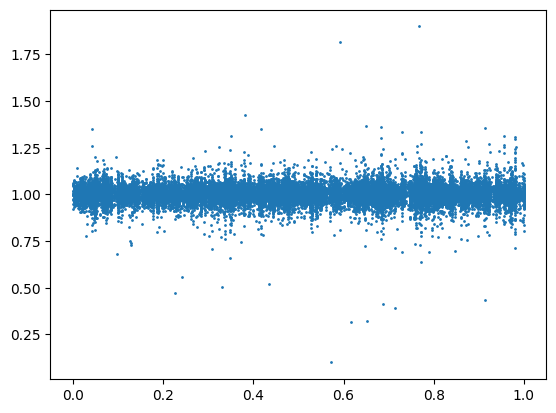

In [46]:
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == 'Fourier_Price_RSMERatioCoeff_1_MH_2')[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, q)
    mask = mask | (arr <= quant)
    return mask

n_q = 15
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.001, 0.10, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum/Xtree.shape[0])
print(returns)

mask = f(0.05)
mask_idc = np.where(mask)[0]
diff_mask = np.diff(np.insert(mask_idc, 0, 1))
idx = np.where(treenames == 'Fourier_Price_RSMERatioCoeff_1_MH_2')[0]
plt.scatter(np.cumsum(diff_mask)/np.sum(diff_mask), ytree[mask], s=1)
plt.show()

### RSME 1 mhx, with out intermediate value

[0.001  0.0019 0.0028 0.0037 0.0046 0.0055 0.0064 0.0073 0.0082 0.0091
 0.01  ]
[0.00157768 0.00289965 0.00416628 0.00545834 0.00676235 0.00800506
 0.0092687  0.01056076 0.01186029 0.01320319 0.01456703]
[1.00325418 1.00325453 1.00288188 1.00287282 1.00263536 1.00290692
 1.00268257 1.00286996 1.00296533 1.00278211 1.0027231 ]


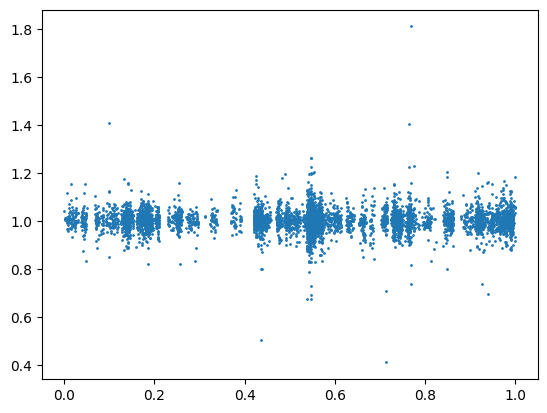

In [47]:
m = 1
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    #idx = np.where(treenames == f'Fourier_Price_RSMECoeff_1_MH_{m}')[0]
    idx2 = np.where(treenames == 'FeatureTA_volatility_atr')[0]
    idx3 = np.where(treenames == f'FeatureTA_trend_kst')[0]
    #arr = Xtree[:, idx].flatten()
    arr2 = Xtree[:, idx2].flatten()
    arr3 = Xtree[:, idx3].flatten()
    #quant = np.quantile(arr, q)
    quant2 = np.quantile(arr2, 1-q)
    quant3 = np.quantile(arr3, q)
    #mask1 = (arr < quant)
    mask2 = (arr2 >= quant2)
    mask3 = (arr3 < quant3)
    mask = mask | ( mask2 | mask3)
    return mask

n_q = 11
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.001, 0.01, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum/Xtree.shape[0])
print(returns)

mask = f(0.01)
mask_idc = np.where(mask)[0]
diff_mask = np.diff(np.insert(mask_idc, 0, 1))
plt.scatter(np.cumsum(diff_mask)/np.sum(diff_mask), ytree[mask], s=1)
plt.show()

# ebit

In [10]:
qm=5
def f(q_l):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    #idx1 = np.where(treenames == f'FinData_quar_ebit_lagquot_qm{qm}')[0]
    idx1 = np.where(treenames == f'FinData_quar_ebitda_lagquot_qm{qm}')[0]
    arr1 = Xtree[:, idx1].flatten()
    #arr2 = Xtree[:, idx2].flatten()
    quant_l = np.quantile(arr1, q_l)
    mask = mask | ((arr1 >= quant_l))
    return mask, quant_l

n_q = 15
masksum = np.zeros(n_q, dtype=int)
quants = np.zeros(n_q)
returns = np.zeros(n_q)
linspace = np.linspace(0.90, 0.97, n_q)
for i, q in enumerate(linspace):
    mask, qi = f(q)
    quants[i] = qi
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum)
print(returns)
print(quants)

fil_df = ls.meta_pl_train.filter(mask)

[0.9   0.905 0.91  0.915 0.92  0.925 0.93  0.935 0.94  0.945 0.95  0.955
 0.96  0.965 0.97 ]
[67020 63657 60299 56984 53657 50269 46933 43561 40256 36882 33505 30152
 26819 23484 20142]
[1.00063026 1.00063157 1.00062072 1.00059366 1.00063872 1.00065339
 1.00066257 1.00068641 1.00070524 1.00071752 1.00071537 1.00078738
 1.0008086  1.00074708 1.00083458]
[1.72156858 1.74934721 1.78097987 1.82323229 1.86279511 1.90987122
 1.96913981 2.01769733 2.08379173 2.16122842 2.27578354 2.37930393
 2.5250783  2.67720771 2.90456843]


# Group Dynamic, FeatureGroup_RetGrLvl

In [49]:
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == f'FeatureGroup_RetGrLvl')[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, q)
    mask = mask | (arr >= quant)
    return mask

n_q = 15
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.95, 0.995, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum)
print(returns)

[0.95       0.95321429 0.95642857 0.95964286 0.96285714 0.96607143
 0.96928571 0.9725     0.97571429 0.97892857 0.98214286 0.98535714
 0.98857143 0.99178571 0.995     ]
[33436 31286 29137 26987 24838 22689 20539 18390 16240 14091 11942  9792
  7643  5493  3344]
[1.00329232 1.00327861 1.00332713 1.00348103 1.00349104 1.00344002
 1.00332391 1.00308084 1.00316048 1.00320351 1.00304723 1.00313568
 1.00283861 1.00264609 1.00237799]


# TA Features

[0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
[11442 10171  8899  7628  6357  5086  3814  2543  1272]
[0.09000378 0.08000598 0.07000031 0.06000252 0.05000472 0.04000692
 0.03000126 0.02000346 0.01000566]
[1.00658345 1.00651085 1.0060277  1.00565565 1.00564992 1.00484669
 1.00565362 1.0073905  1.01332211]


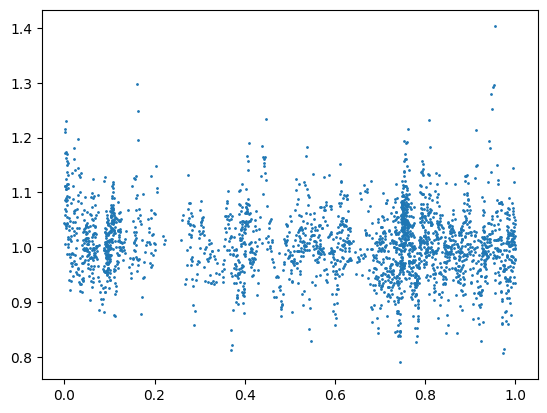

Mean of rolling means: 1.0012939777257255
Std dev of rolling means: 0.002131062154339785


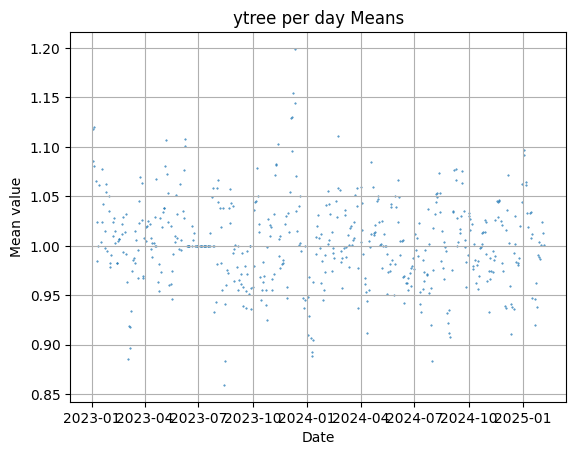

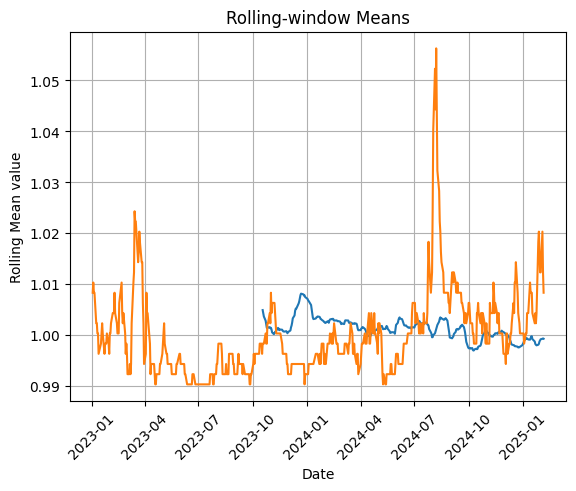

In [67]:
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == 'FeatureTA_volatility_atr')[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, q)
    mask = mask | (arr >= quant)
    return mask

n_q = 9
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.91, 0.99, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum)
print(masksum/Xtree.shape[0])
print(returns)

mask = f(0.98)
mask_idc = np.where(mask)[0]
diff_mask = np.diff(np.insert(mask_idc, 0, 1))
idx = np.where(treenames == 'FeatureTA_volatility_atr')[0]
plt.scatter(np.cumsum(diff_mask)/np.sum(diff_mask), ytree[mask], s=1)
plt.show()

dates = ls.meta_pl_train.select("date").to_series()
datemat = establish_datesMat(dates=dates, device='cpu')

ytree_perdate = datemat[:, mask] @ ytree[mask] / (datemat[:, mask].sum(axis=1) + 1e-10)
n_perdate = (datemat[:, mask].sum(axis=1) + 1e-10)
valid_idx = ytree_perdate > 0.1
ytree_perdate[~valid_idx] = 1.0
dates_valid = dates.unique()

s = pd.Series(ytree_perdate)
rolling_means = s.rolling(window=200).mean()
mean_of_means = rolling_means.mean()
std_of_means  = rolling_means.std()
print("Mean of rolling means:", mean_of_means)
print("Std dev of rolling means:", std_of_means)

plt.scatter(dates_valid, s.values, s=0.2)
plt.title('ytree per day Means')
plt.xlabel('Date')
plt.ylabel('Mean value')
plt.grid(True)
plt.show()

s_perdate = pd.Series(n_perdate)
plt.plot(dates_valid, rolling_means.values)
plt.xticks(rotation=45)
plt.plot(dates_valid, (((s_perdate-s_perdate.mean())/500.0)+1.0).values)
plt.title('Rolling-window Means')
plt.xlabel('Date')
plt.ylabel('Rolling Mean value')
plt.grid(True)
plt.show()

In [52]:
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == f'FeatureTA_trend_kst')[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, q)
    mask = mask | (arr <= quant)
    return mask

n_q = 11
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.01, 0.10, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum)
print(returns)

[0.01  0.019 0.028 0.037 0.046 0.055 0.064 0.073 0.082 0.091 0.1  ]
[ 6688 12706 18724 24742 30761 36780 42797 48816 54834 60852 66871]
[1.00330198 1.00269175 1.00250649 1.00240624 1.00248611 1.00250697
 1.00242162 1.00253141 1.00262415 1.0026226  1.00262225]


[0.91       0.91421053 0.91842105 0.92263158 0.92684211 0.93105263
 0.93526316 0.93947368 0.94368421 0.94789474 0.95210526 0.95631579
 0.96052632 0.96473684 0.96894737 0.97315789 0.97736842 0.98157895
 0.98578947 0.99      ]
[60184 57368 54552 51737 48921 46106 43290 40475 37659 34843 32028 29212
 26397 23581 20765 17950 15134 12319  9503  6688]
[1.00250101 1.00247526 1.00246716 1.00248981 1.00248933 1.00255716
 1.00242352 1.0024215  1.00250089 1.00254703 1.0024122  1.00240147
 1.00231278 1.00239944 1.002298   1.00247884 1.00253558 1.00255001
 1.00259459 1.00271177]


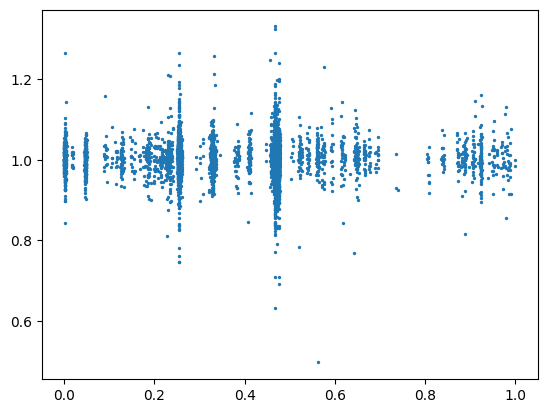

Mean of returns: 1.002513
Mean of rolling means: 1.002464795504673
Std dev of rolling means: 0.0054986001205650885


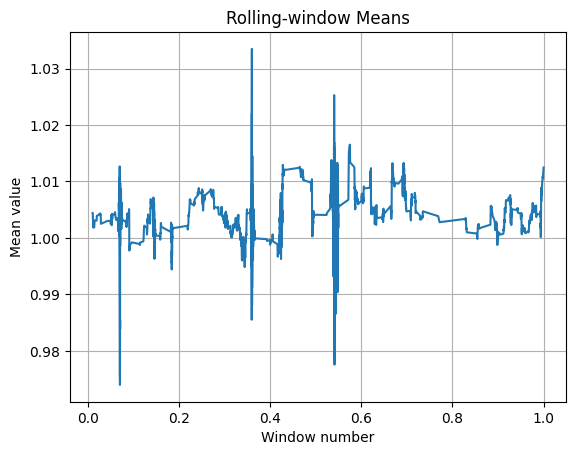

In [54]:
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == f'FeatureTA_trend_mass_index')[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, q)
    mask = mask | (arr >= quant)
    return mask

n_q = 20
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.91, 0.99, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum)
print(returns)

mask = f(0.985)
mask_idc = np.where(mask)[0]
diff_mask = np.diff(np.insert(mask_idc, 0, 1))
dates = ls.meta_pl_train.filter(mask).select("date")

res = ytree[mask]
trunc_rat_low = 0.1
trunc_rat_up = 0.99
res_trunc = res[int(len(res)*trunc_rat_low):int(len(res)*trunc_rat_up)]
diff_mask_trunc = diff_mask[int(len(res)*trunc_rat_low):int(len(res)*trunc_rat_up)]
plt.scatter(np.cumsum(diff_mask_trunc)/np.sum(diff_mask_trunc), res_trunc, s=2)
plt.show()
print("Mean of returns:", np.mean(res_trunc))

s = pd.Series(res)
rolling_means = s.rolling(window=100).mean()
mean_of_means = rolling_means.mean()
std_of_means  = rolling_means.std()
print("Mean of rolling means:", mean_of_means)
print("Std dev of rolling means:", std_of_means)

plt.plot(np.cumsum(diff_mask)/np.sum(diff_mask), rolling_means.values)
plt.title('Rolling-window Means')
plt.xlabel('Window number')
plt.ylabel('Mean value')
plt.grid(True)
plt.show()


# Math Features

In [3]:
candidates = [
    'MathFeature_Drawdown_MH4',
    'MathFeature_Drawdown_MH5',
    'MathFeature_Drawdown_MH6',
]
# find the first one that actually appears in treenames
name = next((c for c in candidates if c in treenames), None)
def f(q):
    mask = np.zeros(Xtree.shape[0], dtype=bool)
    idx = np.where(treenames == name)[0]
    arr = Xtree[:, idx].flatten()
    quant = np.quantile(arr, q)
    mask = mask | (arr <= quant)
    return mask

n_q = 20
masksum = np.zeros(n_q, dtype=int)
returns = np.zeros(n_q)
linspace = np.linspace(0.01, 0.99, n_q)
for i, q in enumerate(linspace):
    mask = f(q)
    masksum[i] = mask.sum()
    returns[i] = np.mean(ytree[mask])

print(linspace)
print(masksum)
print(returns)

mask = f(0.02)
mask_idc = np.where(mask)[0]
diff_mask = np.diff(np.insert(mask_idc, 0, 0))
dates = treetimeML.meta_pl_train.filter(mask).select("date")

s = pd.Series((ytree[mask]))
window=50
rolling_means = s.rolling(window=window).mean()
mean_of_means = rolling_means.mean()
std_of_means  = rolling_means.std()
print("Mean of rolling means:", mean_of_means)
print("Std dev of rolling means:", std_of_means)

plt.plot(np.cumsum(diff_mask)/np.sum(diff_mask), rolling_means.values)
plt.title('Rolling-window Means')
plt.xlabel('Window number')
plt.ylabel('Mean value')
plt.grid(True)
plt.show()

NameError: name 'treenames' is not defined

# ALL at once

In [55]:
q = 0.01
n_feats = Xtree.shape[1]
returns_le = np.zeros(n_feats)
returns_ge = np.zeros(n_feats)

for j in range(n_feats):
    col = Xtree[:, j]
    thresh_low = np.quantile(col, q)
    thresh_high = np.quantile(col, 1 - q)
    mask_le = col <= thresh_low
    mask_ge = col >= thresh_high
    returns_le[j] = np.mean(ytree[mask_le]) if mask_le.any() else np.nan
    returns_ge[j] = np.mean(ytree[mask_ge]) if mask_ge.any() else np.nan

results = pd.DataFrame({
    'feature': treenames,
    f'return_le': returns_le,
    f'return_ge': returns_ge,
}).set_index('feature')

print(results)

                                                return_le  return_ge
feature                                                             
Category_other                                   1.002504   1.002504
Category_industrials                             1.002485   1.002577
Category_healthcare                              1.002548   1.002208
Category_technology                              1.002516   1.002427
Category_financial-services                      1.002518   1.002315
...                                                   ...        ...
FeatureGroup_WeightedIndexMHPct_lag_m500_MH_2    1.002500   1.001944
FeatureGroup_WeightedIndexMHPct_lag_m500_MH_4    1.002509   1.001974
FeatureGroup_WeightedIndexMHPct_lag_m500_MH_6    1.002476   1.003928
FeatureGroup_WeightedIndexMHPct_lag_m500_MH_8    1.002480   1.002212
FeatureGroup_WeightedIndexMHPct_lag_m500_MH_12   1.002496   1.003241

[2829 rows x 2 columns]


In [56]:
res_sorted_le = results.sort_values(by='return_le', ascending=False)
res_sorted_ge = results.sort_values(by='return_ge', ascending=False)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# 1) train
split_ratio      = 0.6
n_total  = Xtree.shape[0]
mask_val = np.random.rand(n_total) >= split_ratio
X, y = Xtree, ytree
tree = DecisionTreeRegressor(max_leaf_nodes=20)  # adjust complexity
tree.fit(X, y)

# 2) leaf assignment & stats
leaf_ids = tree.apply(X)
uniq, counts = np.unique(leaf_ids, return_counts=True)
sums = np.array([y[leaf_ids==lid].sum() for lid in uniq])
# weight = counts, value = sums

# 3) 0/1-knapsack to pick leaves up to 10% of N
N = len(y)
K = int(0.05 * N)
# DP array: dp[w] = max sum achievable with total count w
dp = np.zeros(K+1)
pick = [[False]*len(uniq) for _ in range(K+1)]
for i, (w, v) in enumerate(zip(counts, sums)):
    for cap in range(K, w-1, -1):
        if dp[cap-w] + v > dp[cap]:
            dp[cap] = dp[cap-w] + v
            pick[cap] = pick[cap-w].copy()
            pick[cap][i] = True

# find best cap
best_w = np.argmax(dp)
chosen = [uniq[i] for i, used in enumerate(pick[best_w]) if used]

# 4) extract your subset
mask = np.isin(leaf_ids, chosen)
X_sel, y_sel = X[mask], y[mask]

print(f"Selected {len(y_sel)} samples (target mean={y_sel.mean():.3f})")

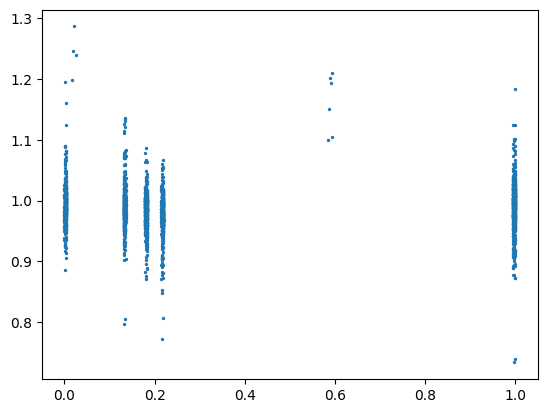

Mean of returns: 0.9879441
Mean of rolling means: 0.9879817862830802
Std dev of rolling means: 0.009214363115414287


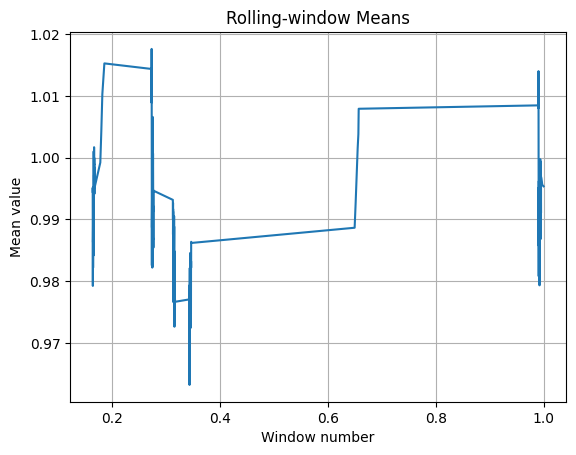

In [ ]:

mask_idc = np.where(mask)[0]
diff_mask = np.diff(np.insert(mask_idc, 0, 0))
dates = treetimeML.meta_pl_train.filter(mask).select("date")

res = ytree[mask]
trunc_rat_low = 0.02
trunc_rat_up = 0.99
res_trunc = res[int(len(res)*trunc_rat_low):int(len(res)*trunc_rat_up)]
diff_mask_trunc = diff_mask[int(len(res)*trunc_rat_low):int(len(res)*trunc_rat_up)]
plt.scatter(np.cumsum(diff_mask_trunc)/np.sum(diff_mask_trunc), res_trunc, s=2)
plt.show()
print("Mean of returns:", np.mean(res_trunc))

s = pd.Series((ytree[mask]))
window=50
rolling_means = s.rolling(window=window).mean()
mean_of_means = rolling_means.mean()
std_of_means  = rolling_means.std()
print("Mean of rolling means:", mean_of_means)
print("Std dev of rolling means:", std_of_means)

plt.plot(np.cumsum(diff_mask)/np.sum(diff_mask), rolling_means.values)
plt.title('Rolling-window Means')
plt.xlabel('Window number')
plt.ylabel('Mean value')
plt.grid(True)
plt.show()

## Combining all Feat

In [ ]:
df = pl.DataFrame({
    **{f"f{i}": Xtree[:,i] for i in range(n_feats)},
    "y":            ytree,
    "date":         treetimeML.meta_pl_train["date"]
})
long = df.melt(id_vars=["y","date"], variable_name="feature", value_name="value")

C:\Users\kimer\AppData\Local\Temp\ipykernel_14228\1062238412.py:6: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  long = df.melt(id_vars=["y","date"], variable_name="feature", value_name="value")


In [ ]:
q_arr = [0.005, 0.01, 0.02]
n_samples, n_feats = Xtree.shape
n_q = len(q_arr)
roll_window=200
returns_le = np.zeros((n_feats, n_q))
returns_ge = np.zeros((n_feats, n_q))
num_le     = np.zeros((n_feats, n_q), dtype=int)
num_ge     = np.zeros((n_feats, n_q), dtype=int)
roll_le_mean  = np.zeros((n_feats, n_q))
roll_le_stderr = np.zeros((n_feats, n_q))
roll_le_end_mean = np.zeros((n_feats, n_q))
roll_ge_mean  = np.zeros((n_feats, n_q))
roll_ge_stderr = np.zeros((n_feats, n_q))
roll_ge_end_mean = np.zeros((n_feats, n_q))
days_le = np.zeros((n_feats, n_q), dtype=int)
days_ge = np.zeros((n_feats, n_q), dtype=int)

for i, q in enumerate(q_arr):
    print(f"Processing quantile: {q}")
    
    thr_low  = np.quantile(Xtree,      q, axis=0)
    thr_high = np.quantile(Xtree, 1. - q, axis=0)

    # 2) boolean masks of shape (n_samples, n_feats)
    mask_le = Xtree <= thr_low
    mask_ge = Xtree >= thr_high
    
    # 3) vectorized sums & counts → means
    cnt_le = mask_le.sum(axis=0)
    cnt_ge = mask_ge.sum(axis=0)
    sum_le = (mask_le * ytree[:, None]).sum(axis=0)
    sum_ge = (mask_ge * ytree[:, None]).sum(axis=0)

    num_le[:, i]     = cnt_le
    num_ge[:, i]     = cnt_ge
    returns_le[:, i] = np.where(cnt_le>0, sum_le/cnt_le, np.nan)
    returns_ge[:, i] = np.where(cnt_ge>0, sum_ge/cnt_ge, np.nan)
    
    for j in range(n_feats):
        # roll le
        df_le = pl.DataFrame({"value": ytree[mask_le[:,j]]})
        df_le = (df_le.with_columns(pl.col("value")
                .rolling_mean(roll_window)
                .alias("rolling_mean"))
            .drop_nulls("rolling_mean"))
        stats_le = df_le.select([
            pl.col("rolling_mean").mean().alias("roll_mean"),
            pl.col("rolling_mean").std().alias("roll_stderr"),
            pl.col("rolling_mean").last().alias("roll_end_mean"),
        ])
        roll_le_mean[j, i]     = stats_le["roll_mean"][0]
        roll_le_stderr[j, i]   = stats_le["roll_stderr"][0]
        roll_le_end_mean[j, i] = stats_le["roll_end_mean"][0]
        
        # roll ge
        df_ge = pl.DataFrame({"value": ytree[mask_ge[:,j]]})
        df_ge = (df_ge.with_columns(pl.col("value")
                .rolling_mean(roll_window)
                .alias("rolling_mean"))
            .drop_nulls("rolling_mean"))
        stats_ge = df_ge.select([
            pl.col("rolling_mean").mean().alias("roll_mean"),
            pl.col("rolling_mean").std().alias("roll_stderr"),
            pl.col("rolling_mean").last().alias("roll_end_mean"),
        ])
        roll_ge_mean[j, i]     = stats_ge["roll_mean"][0]
        roll_ge_stderr[j, i]   = stats_ge["roll_stderr"][0]
        roll_ge_end_mean[j, i] = stats_ge["roll_end_mean"][0]
        
        # dates
        days_le[j, i] = treetimeML.meta_pl_train.filter(mask_le[:,j]).select("date").unique().to_series().sort().diff().drop_nans().max().days
        days_ge[j, i] = treetimeML.meta_pl_train.filter(mask_ge[:,j]).select("date").unique().to_series().sort().diff().drop_nans().max().days


results = pl.DataFrame({
    'feature': treenames,
    **{f'return_le_{int(q*1000)}': returns_le[:,i] for i, q in enumerate(q_arr)},
    **{f'return_ge_{int(q*1000)}': returns_ge[:,i] for i, q in enumerate(q_arr)},
    **{f'num_le_{int(q*1000)}': num_le[:,i] for i, q in enumerate(q_arr)},
    **{f'num_ge_{int(q*1000)}': num_ge[:,i] for i, q in enumerate(q_arr)},
    **{f'roll_le_mean_{int(q*1000)}': roll_le_mean[:,i] for i, q in enumerate(q_arr)},
    **{f'roll_le_stderr_{int(q*1000)}': roll_le_stderr[:,i] for i, q in enumerate(q_arr)},
    **{f'roll_le_end_mean_{int(q*1000)}': roll_le_end_mean[:,i] for i, q in enumerate(q_arr)},
    **{f'roll_ge_mean_{int(q*1000)}': roll_ge_mean[:,i] for i, q in enumerate(q_arr)},
    **{f'roll_ge_stderr_{int(q*1000)}': roll_ge_stderr[:,i] for i, q in enumerate(q_arr)},
    **{f'roll_ge_end_mean_{int(q*1000)}': roll_ge_end_mean[:,i] for i, q in enumerate(q_arr)},
    **{f'days_le_{int(q*1000)}': days_le[:,i] for i, q in enumerate(q_arr)},
    **{f'days_ge_{int(q*1000)}': days_ge[:,i] for i, q in enumerate(q_arr)},
})

results

Processing quantile: 0.005
Processing quantile: 0.01
Processing quantile: 0.02


feature,return_le_5,return_le_10,return_le_20,return_ge_5,return_ge_10,return_ge_20,num_le_5,num_le_10,num_le_20,num_ge_5,num_ge_10,num_ge_20,roll_le_mean_5,roll_le_mean_10,roll_le_mean_20,roll_le_stderr_5,roll_le_stderr_10,roll_le_stderr_20,roll_le_end_mean_5,roll_le_end_mean_10,roll_le_end_mean_20,roll_ge_mean_5,roll_ge_mean_10,roll_ge_mean_20,roll_ge_stderr_5,roll_ge_stderr_10,roll_ge_stderr_20,roll_ge_end_mean_5,roll_ge_end_mean_10,roll_ge_end_mean_20,days_le_5,days_le_10,days_le_20,days_ge_5,days_ge_10,days_ge_20
str,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64
"""Category_other""",1.002424,1.002424,1.002424,1.002424,1.002424,1.002424,668331,668331,668331,668331,668331,668331,1.002489,1.002489,1.002489,0.0214,0.0214,0.0214,1.002057,1.002057,1.002057,1.002489,1.002489,1.002489,0.0214,0.0214,0.0214,1.002057,1.002057,1.002057,4,4,4,4,4,4
"""Category_industrials""",1.002504,1.002504,1.002504,1.002453,1.002453,1.002453,528588,528588,528588,139743,139743,139743,1.002497,1.002497,1.002497,0.021229,0.021229,0.021229,1.002556,1.002556,1.002556,1.002454,1.002454,1.002454,0.01926,0.01926,0.01926,1.000829,1.000829,1.000829,4,4,4,4,4,4
"""Category_healthcare""",1.002478,1.002478,1.002478,1.002276,1.002276,1.002276,581607,581607,581607,86724,86724,86724,1.002519,1.002519,1.002519,0.021527,0.021527,0.021527,1.004851,1.004851,1.004851,1.002285,1.002285,1.002285,0.016417,0.016417,0.016417,0.985975,0.985975,0.985975,4,4,4,4,4,4
"""Category_technology""",1.002386,1.002386,1.002386,1.002901,1.002901,1.002901,578937,578937,578937,89394,89394,89394,1.002425,1.002425,1.002425,0.021241,0.021241,0.021241,1.003708,1.003708,1.003708,1.002905,1.002905,1.002905,0.017867,0.017867,0.017867,0.998674,0.998674,0.998674,4,4,4,4,4,4
"""Category_financial-services""",1.00244,1.00244,1.00244,1.002673,1.002673,1.002673,623372,623372,623372,44959,44959,44959,1.002475,1.002475,1.002475,0.021419,0.021419,0.021419,1.005988,1.005988,1.005988,1.00272,1.00272,1.00272,0.013439,0.013439,0.013439,0.991525,0.991525,0.991525,4,4,4,4,4,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""FeatureGroup_WeightedIndexMHPc…",1.002461,1.002461,1.002461,1.001007,1.004588,1.004603,621933,621933,621933,5639,7787,32866,1.002508,1.002508,1.002508,0.020933,0.020933,0.020933,1.002468,1.002468,1.002468,1.001181,1.004808,1.004652,0.015772,0.017813,0.017486,1.003049,1.003049,1.003049,7,7,7,2766,1203,217
"""FeatureGroup_WeightedIndexMHPc…",1.002471,1.002471,1.002471,0.996333,0.998737,0.998737,624379,624379,624379,3821,17678,17678,1.002518,1.002518,1.002518,0.021639,0.021639,0.021639,1.002057,1.002057,1.002057,0.99603,0.998802,0.998802,0.010908,0.013782,0.013782,1.020964,1.006604,1.006604,6,6,6,2719,870,870
"""FeatureGroup_WeightedIndexMHPc…",1.002403,1.002403,1.002403,0.999037,1.002837,1.001599,624518,624518,624518,4444,12802,32125,1.002463,1.002463,1.002463,0.021272,0.021272,0.021272,1.002057,1.002057,1.002057,0.999313,1.002883,1.001605,0.014522,0.017267,0.021234,0.992038,0.992038,0.992038,6,6,6,2798,1043,371


In [ ]:
names_le = ([f"roll_le_end_mean_{int(q*1000)}" for q in q_arr])
names_ge = ([f"roll_ge_end_mean_{int(q*1000)}" for q in q_arr])

res = results.with_columns([
    pl.col(f"roll_le_end_mean_{int(q*1000)}").alias(f"score_raw_le_q{q}") for q in q_arr
] + [
    pl.col(f"roll_ge_end_mean_{int(q*1000)}").alias(f"score_raw_ge_q{q}") for q in q_arr
])

res = res.with_columns([
        (pl.col(f"roll_le_end_mean_{int(q*1000)}") 
            * pl.when(pl.col(f'num_le_{int(q*1000)}') < (n_samples*q)).then(0.0).otherwise(1.0)
            * pl.when((1.0 - pl.col(f'roll_le_stderr_{int(q*1000)}')) < 0).then(0.0).otherwise((1.0 - pl.col(f'roll_le_stderr_{int(q*1000)}')))
            * pl.when(pl.col(f'days_le_{int(q*1000)}') > 100.0).then(0.0).otherwise(1.0))
        .alias(f"score_le_q{q}") for q in q_arr
    ] + [
        (pl.col(f"roll_ge_end_mean_{int(q*1000)}")
            * pl.when(pl.col(f'num_ge_{int(q*1000)}') < (n_samples*q)).then(0.0).otherwise(1.0)
            * pl.when(pl.when(pl.col(f'num_ge_{int(q*1000)}') < (n_samples*q)).then(0.0).otherwise(1.0) < 0).then(0.0).otherwise(pl.when(pl.col(f'num_ge_{int(q*1000)}') < (n_samples*q)).then(0.0).otherwise(1.0))
            * pl.when(pl.col(f'days_ge_{int(q*1000)}') > 100.0).then(0.0).otherwise(1.0))
        .alias(f"score_ge_q{q}") for q in q_arr
    ])

res = res.with_columns([
    (pl.when(pl.col(f"score_le_q{q}") > pl.col(f"score_ge_q{q}")).then(pl.col(f"score_le_q{q}"))
        .otherwise(pl.col(f"score_ge_q{q}")))
    .alias(f"score_q{q}") 
    for q in q_arr
])
    
scores_df = res.select(['feature'] + [f"score_raw_le_q{q}" for q in q_arr] + [f"score_raw_ge_q{q}" for q in q_arr] + [f"score_le_q{q}" for q in q_arr] + [f"score_ge_q{q}" for q in q_arr] + [f"score_q{q}" for q in q_arr])